In [31]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder,Discriminator


from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
n_z = 10
n_data = 5000
n_batch = 128
n_iter = 10
n_linear = torch.combinations(torch.arange(n_z+1), with_replacement=True).shape[0]

In [4]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)

In [33]:
spectra = torch.tensor(dataset[0:20000][0]).to(device)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [34]:
def expand(tensor):
    """returns polynomialfeatures of order 2 of z"""
    indexes = torch.combinations(torch.arange(tensor.shape[1]), with_replacement=True).to(device)
    left = torch.index_select(tensor, 1, indexes[:,0])
    right = torch.index_select(tensor, 1, indexes[:,1])
    return left*right

In [7]:
linear =torch.randn(n_linear,spectra.shape[1]).to(device)

In [119]:
z = torch.randn(spectra.shape[0],n_z).to(device)
z.requires_grad = True

In [120]:
loss = torch.nn.L1Loss()

In [121]:
optimizer = torch.optim.Adam([z], lr=0.5)

In [11]:
expand(z).shape

torch.Size([20000, 55])

In [12]:
z.shape

torch.Size([20000, 10])

In [13]:
linear.shape

torch.Size([66, 8575])

In [46]:
print(z)

tensor([[ 0.2220, -0.6553, -0.9494,  ..., -0.2717,  0.0870, -1.7820],
        [ 0.3406,  0.9132,  1.2527,  ..., -0.4672, -0.4464, -0.3207],
        [-0.9812, -1.0204,  0.2596,  ..., -1.3531,  0.4056, -1.1474],
        ...,
        [-0.3669,  0.1393,  2.0631,  ...,  2.1544, -0.2905, -1.3617],
        [ 1.2938, -0.4885,  0.5698,  ..., -0.1350,  1.0873, -0.3917],
        [ 0.3054,  1.5594, -0.6774,  ..., -0.1846,  0.1554, -0.0241]],
       device='cuda:0', requires_grad=True)


In [52]:
for i in range(1000):
    ones = torch.ones(len(z),1).to(device)
    z_val = torch.cat((z,ones),dim=1)
    linear = torch.mm(torch.pinverse(z_val.detach()),spectra)
    spectra_pred = torch.mm(z_val,linear)
    err = loss(spectra_pred,spectra)
    optimizer.zero_grad()
    err.backward()
    optimizer.step()
    print(err.item())

6.859572022221982e-05
6.855483661638573e-05
6.85203485772945e-05
6.849109195172787e-05
6.846606993349269e-05
6.844446033937857e-05
6.84256010572426e-05
6.840893911430612e-05
6.839403067715466e-05
6.838052649982274e-05
6.836812826804817e-05
6.835663225501776e-05
6.834584200987592e-05
6.833562656538561e-05
6.83258767821826e-05
6.831650534877554e-05
6.830745405750349e-05
6.829866470070556e-05
6.829010817455128e-05
6.828174809925258e-05
6.827356264693663e-05
6.82655445416458e-05
6.825767195550725e-05
6.824995944043621e-05
6.824237061664462e-05
6.82349200360477e-05
6.822760769864544e-05
6.822042632848024e-05
6.821336137363687e-05
6.820644193794578e-05
6.819963891757652e-05
6.819297414040193e-05
6.818643305450678e-05
6.818001565989107e-05
6.81737219565548e-05
6.816755194449797e-05
6.816150562372059e-05
6.815557571826503e-05
6.814976950408891e-05
6.8144072429277e-05
6.813849904574454e-05
6.813303480157629e-05
6.812767242081463e-05
6.812243373133242e-05
6.811728235334158e-05
6.811224739067256e

KeyboardInterrupt: 

In [123]:
for i in range(1000):
    ones = torch.ones(len(z),1).to(device)
    z_val = torch.cat((z,ones),dim=1)
    z_val = expand(z)
    linear = torch.mm(torch.pinverse(z_val.detach()),spectra)
    spectra_pred = torch.mm(z_val,linear)
    err = loss(spectra_pred,spectra)
    optimizer.zero_grad()
    err.backward()
    optimizer.step()
    if i%30==0:
        print(err.item())

0.005005089100450277
0.005008426494896412


KeyboardInterrupt: 

In [ ]:
plt.plot(spectra_pred[0].cpu().detach())
plt.plot(spectra[0].cpu().detach())
plt.xlim(1200,1500)

In [129]:
z_np = z.detach().cpu().numpy()

In [68]:
z_np.shape

(20000, 10)

In [111]:
z[0]/2.5354

tensor([ 1.0000,  0.4047, -1.5385,  3.7552,  1.6529, -0.8631,  1.1964, -0.0954,
        -3.5473,  1.3968], device='cuda:0', grad_fn=<DivBackward0>)

In [80]:
z_np[0]/2.2063975

array([ 1.        ,  0.5875271 , -1.7310187 ,  4.354386  ,  1.9813946 ,
       -0.6935947 ,  1.7983116 , -0.01378218, -4.105302  ,  1.0301151 ],
      dtype=float32)

### Polynomial expansion

In [124]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [125]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [133]:
z_vec = vector.Vector(z_np[:n_data][combined_cut[:n_data]],order=1,interaction_only=False)

In [134]:
w = vector.LinearTransformation(z_vec,y)


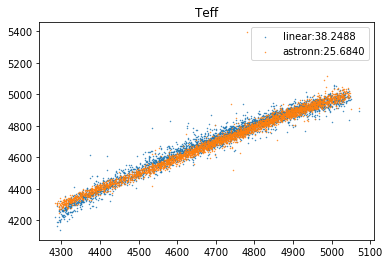

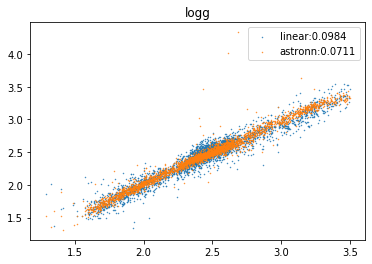

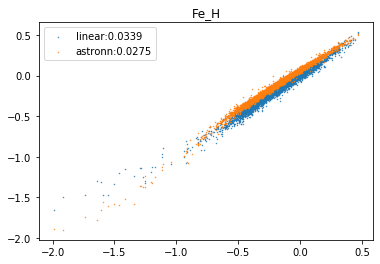

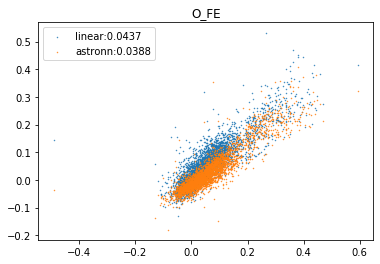

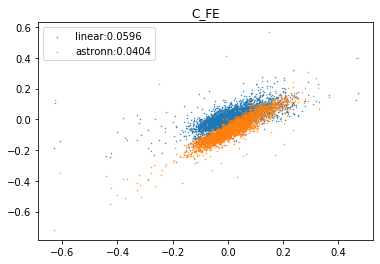

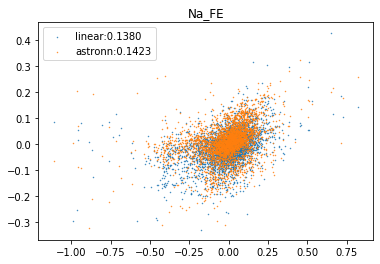

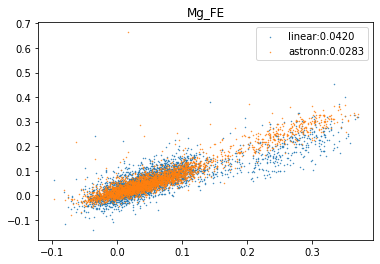

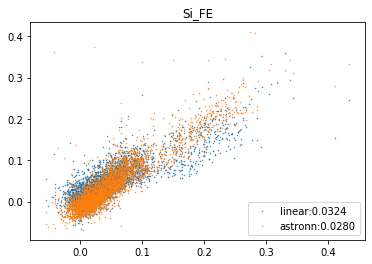

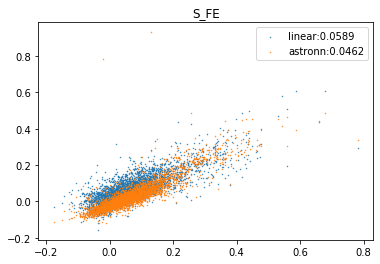

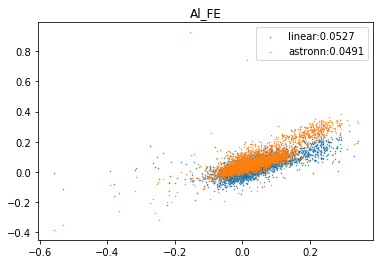

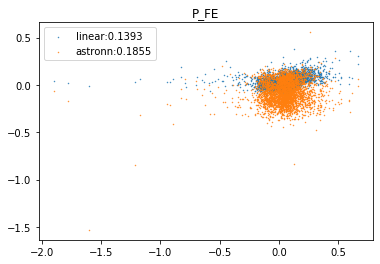

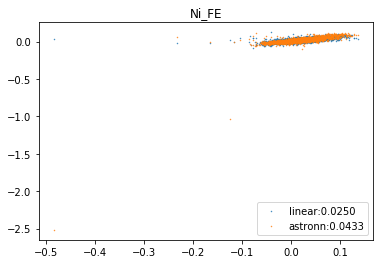

In [135]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

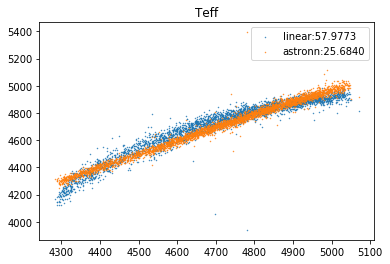

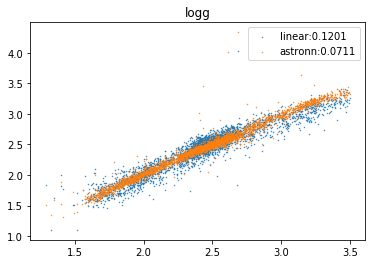

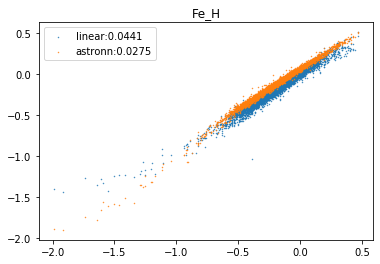

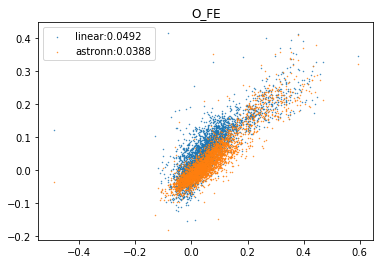

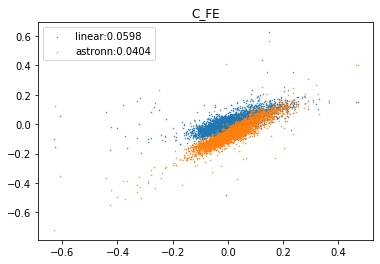

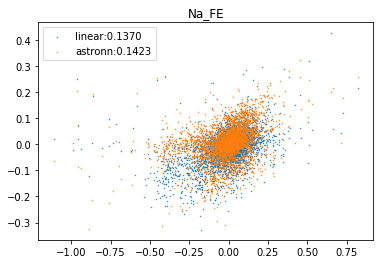

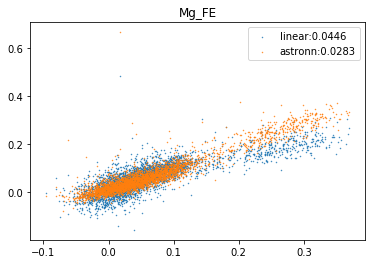

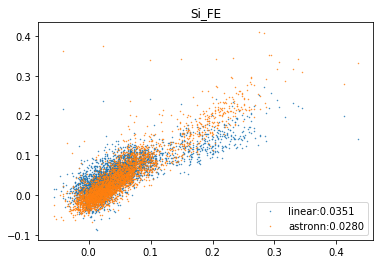

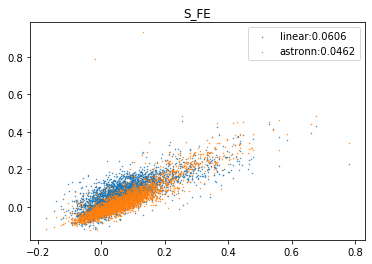

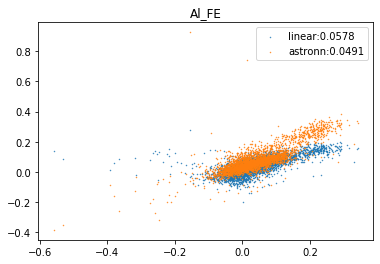

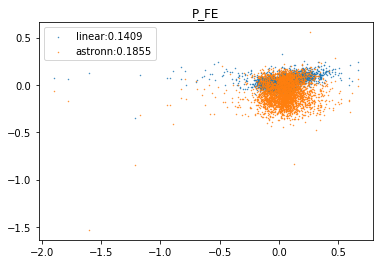

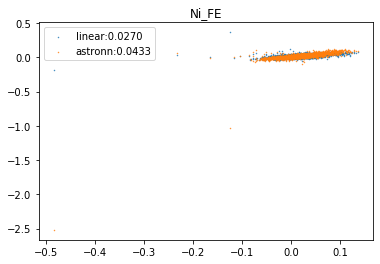

In [115]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [181]:
import sklearn
ridge = sklearn.linear_model.LinearRegression()

In [182]:
ridge.fit(z_val.detach().cpu().numpy(),spectra.detach().cpu().numpy())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [183]:
np.max(ridge.coef_)

0.00050448056